Import required libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from src.data_processing import DataProcessor

Load and explore the data

In [2]:
data_dir = 'data/raw'  
processor = DataProcessor(data_dir)
data = processor.preprocess()

# Display basic info
print("Data Shape:", data.shape)
print("\nData Types:\n", data.dtypes)
print("\nMissing Values:\n", data.isnull().sum())

Data Shape: (150, 13)

Data Types:
 customer_id_legacy                 object
transaction_id                      int64
purchase_amount                     int64
purchase_date              datetime64[ns]
product_category                   object
customer_rating                   float64
customer_id_new                    object
social_media_platform              object
engagement_score                  float64
purchase_interest_score           float64
review_sentiment                   object
purchase_month                      int32
purchase_dayofweek                  int32
dtype: object

Missing Values:
 customer_id_legacy           0
transaction_id               0
purchase_amount              0
purchase_date                0
product_category             0
customer_rating              0
customer_id_new            150
social_media_platform        0
engagement_score             0
purchase_interest_score      0
review_sentiment             0
purchase_month               0
purchase_dayof

c:\Users\HP\Downloads\audio_image-processing-\product_recommendation_system\venv\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\HP\Downloads\audio_image-processing-\product_recommendation_system\venv\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Exploratory Data Analysis - Product Categories

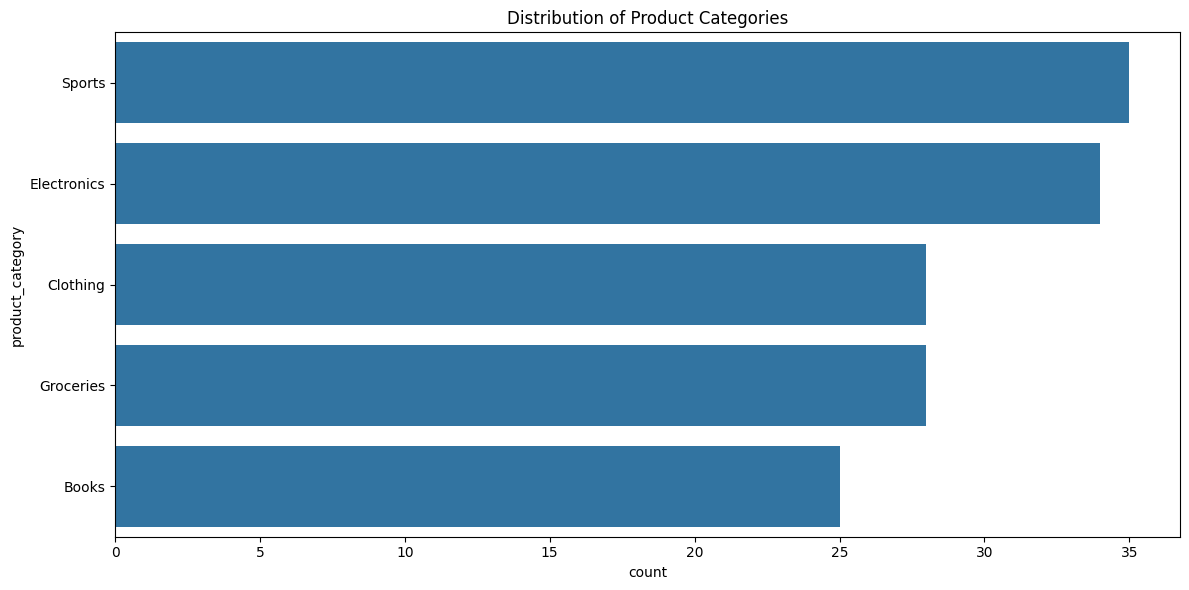

In [3]:
plt.figure(figsize=(12, 6))
sns.countplot(y='product_category', data=data)
plt.title('Distribution of Product Categories')
plt.tight_layout()
plt.show()

Exploratory Data Analysis - Numeric Features

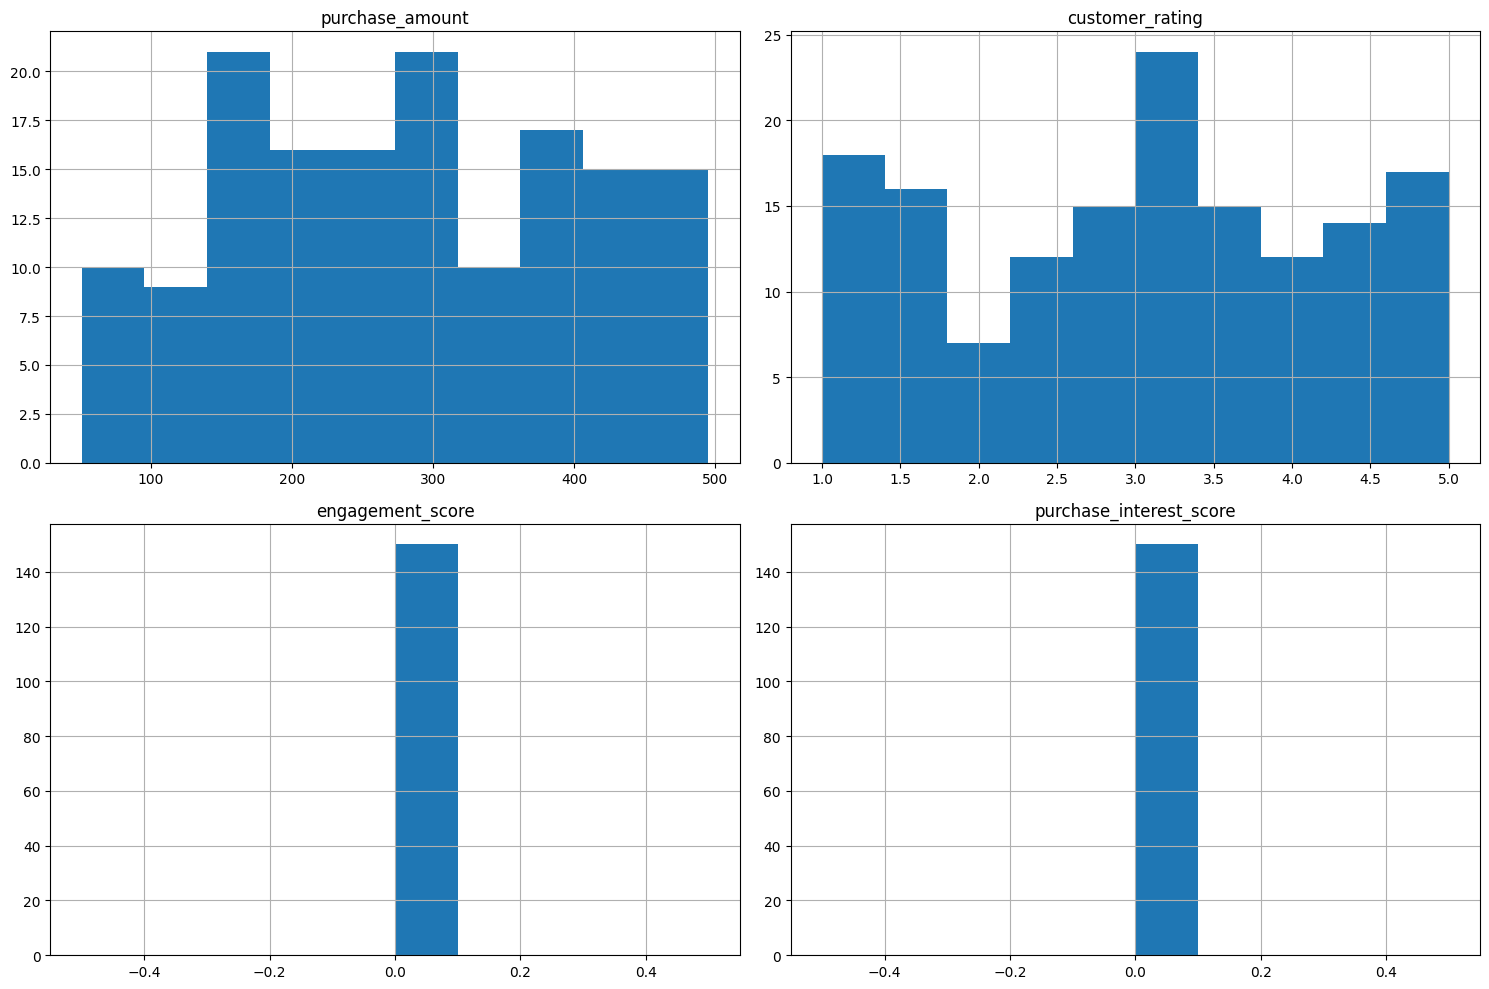

In [4]:
numeric_cols = ['purchase_amount', 'customer_rating', 'engagement_score', 'purchase_interest_score']
data[numeric_cols].hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

Correlation Analysis

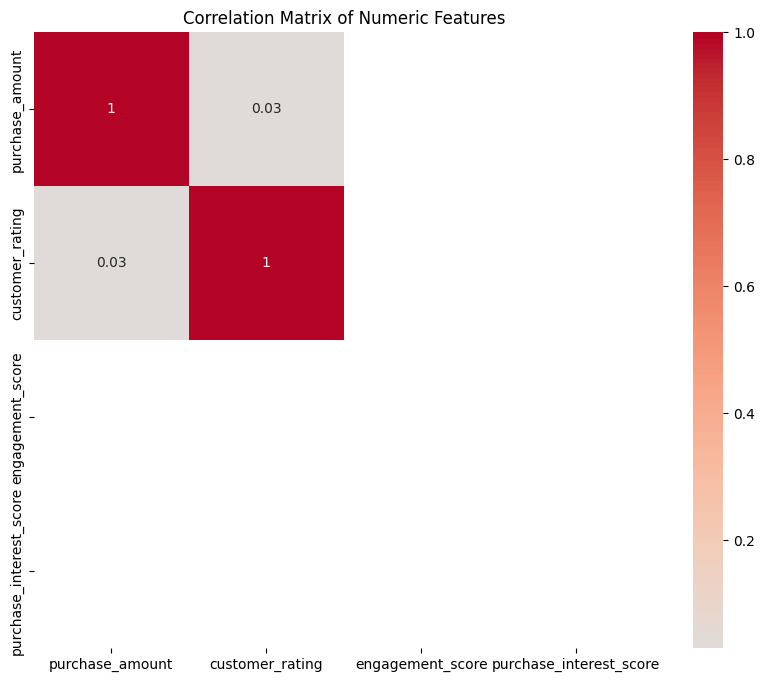

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Features')
plt.show()


Prepare data for modeling

In [6]:
X_train, X_test, y_train, y_test, preprocessor = processor.prepare_data()
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (120, 8)
Test set shape: (30, 8)


Train XGBoost model

In [7]:
xgb_model = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

Model Evaluation

In [8]:
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=processor.label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

       Books       0.12      0.20      0.15         5
    Clothing       0.25      0.17      0.20         6
 Electronics       0.17      0.14      0.15         7
   Groceries       0.00      0.00      0.00         5
      Sports       0.25      0.29      0.27         7

    accuracy                           0.17        30
   macro avg       0.16      0.16      0.15        30
weighted avg       0.17      0.17      0.16        30



Confusion Matrix

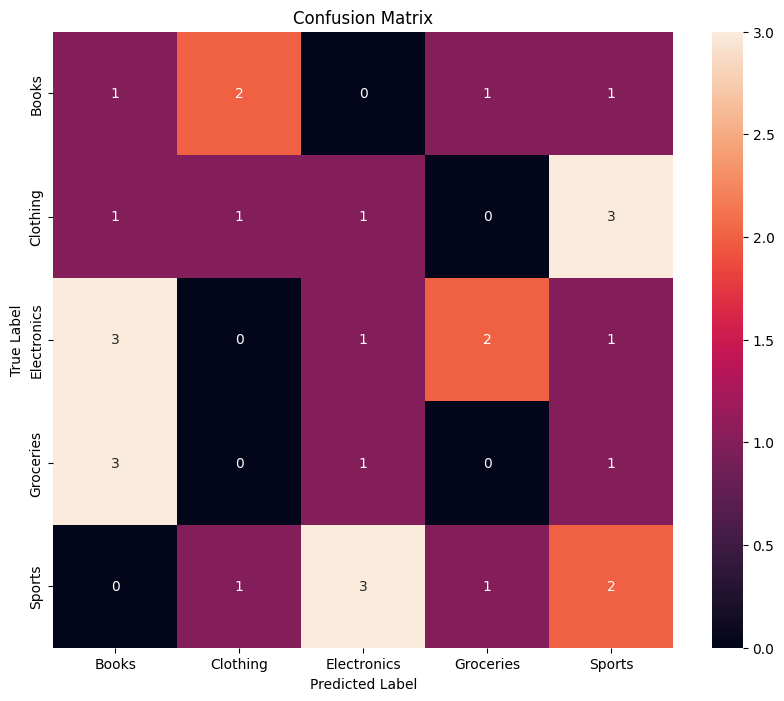

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d',
            xticklabels=processor.label_encoder.classes_,
            yticklabels=processor.label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Feature Importance

<Figure size 1200x800 with 0 Axes>

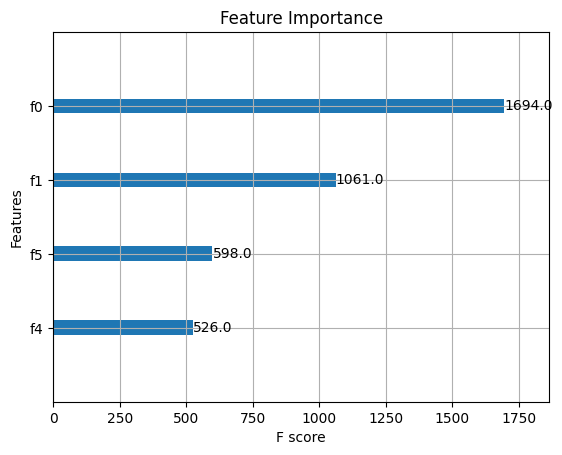

In [10]:
plt.figure(figsize=(12, 8))
plot_importance(xgb_model, max_num_features=15)
plt.title('Feature Importance')
plt.show()

Save the trained model

In [11]:
import joblib
os.makedirs('models', exist_ok=True)
joblib.dump(xgb_model, 'models/product_recommender_xgb.joblib')
print("Model saved successfully!")

Model saved successfully!


Recommendation Function

In [14]:
def get_recommendations(customer_data, model, preprocessor, label_encoder, top_n=3):
    """
    Get product recommendations for a customer based on their data.
    
    Args:
        customer_data (DataFrame): DataFrame containing customer features
        model: Trained model (XGBoost)
        preprocessor: Fitted preprocessor
        label_encoder: Fitted label encoder
        top_n (int): Number of top recommendations to return
        
    Returns:
        DataFrame: Top N product recommendations with their probabilities
    """
    try:
        # Ensure customer_data is a DataFrame
        if not isinstance(customer_data, pd.DataFrame):
            customer_data = pd.DataFrame([customer_data])
            
        # Preprocess the input data
        try:
            processed_data = preprocessor.transform(customer_data)
        except Exception as e:
            print("Error in preprocessing data:", str(e))
            return None
            
        # Get prediction probabilities
        probas = model.predict_proba(processed_data)[0]
        
        # Create a DataFrame with product categories and their probabilities
        recommendations = pd.DataFrame({
            'product_category': label_encoder.classes_,
            'probability': probas
        })
        
        # Sort by probability and get top N
        top_recommendations = recommendations.sort_values('probability', ascending=False).head(top_n)
        
        # Format the output
        top_recommendations['probability'] = top_recommendations['probability'].apply(lambda x: f"{x:.2%}")
        
        # Reset index for cleaner output
        top_recommendations = top_recommendations.reset_index(drop=True)
        
        return top_recommendations
    
    except Exception as e:
        print(f"Error generating recommendations: {str(e)}")
        return None


In [18]:
sample_customer = {
    'purchase_amount': 150,
    'customer_rating': 4.5,
    'engagement_score': 75,
    'purchase_interest_score': 4.2,
    'social_media_platform': 'Facebook',
    'review_sentiment': 'Positive',
    'purchase_month': 6,
    'purchase_dayofweek': 2
}

recommendations = get_recommendations(
    sample_customer,
    xgb_model,
    preprocessor,
    processor.label_encoder,
    top_n=3
)
print(recommendations)

  product_category probability
0           Sports      66.71%
1            Books      22.57%
2      Electronics       5.21%


Cross-validation

In [17]:
print("\nCross-validation scores:")
scores = cross_val_score(xgb_model, 
                        np.vstack([X_train, X_test]), 
                        np.concatenate([y_train, y_test]),
                        cv=5)
print(f"Mean CV Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")


Cross-validation scores:
Mean CV Accuracy: 0.1600 (+/- 0.0653)
